In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00


In [3]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [4]:
import tensorflow as tf

In [5]:
# Import libraries
import sys
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [18]:
train_original_2D = np.load('/content/drive/MyDrive/2DPart/2Dnpy/2D_train_original2.npy')
train_mask_2D = np.load('/content/drive/MyDrive/2DPart/2Dnpy/2D_train_mask2.npy')
validation_original_2D = np.load('/content/drive/MyDrive/2DPart/2Dnpy/2D_validation_original2.npy')
validation_mask_2D = np.load('/content/drive/MyDrive/2DPart/2Dnpy/2D_validation_mask2.npy')
#test_original_2D = np.load('/content/drive/MyDrive/2DPart/2Dnpy/2D_test_original2.npy')
#test_mask_2D = np.load('/content/drive/MyDrive/2DPart/2Dnpy/2D_test_mask2.npy')

In [ ]:
print("Shape of the data:", train_original_2D.shape)
print("Shape of the data:", train_mask_2D.shape)

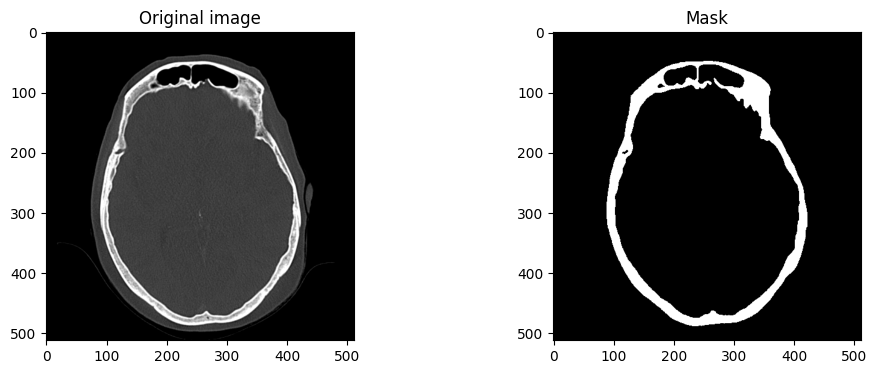

In [7]:
# Check the images 2D
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(train_original_2D[443,:,:,0], cmap='gray')
axes[0].set_title('Original image')

axes[1].imshow(train_mask_2D[443,:,:,0], cmap='gray')
axes[1].set_title('Mask')

plt.show()

In [19]:
LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

In [8]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [9]:
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [20]:
# others: vgg16, resnet50
backbone = 'resnet50' #resnet50, vgg16
preprocess_input = sm.get_preprocessing(backbone)

In [21]:
train_original_2D = preprocess_input(train_original_2D)
validation_original_2D = preprocess_input(validation_original_2D)
#test_original_2D = preprocess_input(test_original_2D)

In [22]:
# Define the model
model = sm.Unet(backbone, classes=2,
                input_shape=(512, 512, 3),
                encoder_weights='imagenet',
                activation='sigmoid')

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, 512, 512, 3)          9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d_18 (ZeroPad  (None, 518, 518, 3)          0         ['bn_data[0][0]']             
 ding2D)                                                                                          
                                                                                            

In [ ]:
from tensorflow.keras.callbacks import Callback

In [ ]:
class SavePredictionsCallback(Callback):
    def __init__(self, validation_data, save_dir):
        super(SavePredictionsCallback, self).__init__()
        self.validation_data = validation_data
        self.save_dir = save_dir

    def on_epoch_end(self, epoch, logs=None):
        predicted_masks = self.model.predict(self.validation_data[0])

        for i in range(len(self.validation_data[0])):
            self.save_or_visualize_results(
                self.validation_data[0][i],
                self.validation_data[1][i],
                predicted_masks[i],
                epoch,
                i
            )

    def save_or_visualize_results(self, input_image, true_mask, predicted_mask, epoch, sample_idx):
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        axes[0].imshow(input_image[:,:,0], cmap='gray')
        axes[0].set_title('Input Image')

        axes[1].imshow(true_mask[:,:,0], cmap='gray')
        axes[1].set_title('True Mask')

        axes[2].imshow(predicted_mask[:,:,0], cmap='gray')
        axes[2].set_title('Predicted Mask')

        plt.savefig(os.path.join(self.save_dir, f'epoch_{epoch}_sample_{sample_idx}.png'))
        plt.close()

In [ ]:
save_dir_resn = '/content/drive/MyDrive/2DPart/Model_training_prediction/resnet50'
save_dir_vgg = '/content/drive/MyDrive/2DPart/Model_training_prediction/vgg16'
os.makedirs(save_dir_resn, exist_ok=True) # save_dir_vgg, save_dir_resn

save_predictions_callback = SavePredictionsCallback(validation_data=(validation_original_2D, validation_mask_2D),
                                                    save_dir=save_dir_resn) # save_dir_vgg, save_dir_resn

In [23]:
history=model.fit(train_original_2D,
          train_mask_2D,
          batch_size=4,
          epochs=40,
          verbose=1,
          validation_data=(validation_original_2D, validation_mask_2D))
          #callbacks=[save_predictions_callback])

Epoch 1/40
112/112 [==============================] - 51s 109ms/step - loss: 0.4316 - iou_score: 0.6272 - f1-score: 0.7182 - val_loss: 0.4457 - val_iou_score: 0.6896 - val_f1-score: 0.7841
Epoch 2/40
112/112 [==============================] - 8s 75ms/step - loss: 0.3196 - iou_score: 0.8433 - f1-score: 0.9077 - val_loss: 0.3166 - val_iou_score: 0.8806 - val_f1-score: 0.9332
Epoch 3/40
112/112 [==============================] - 8s 75ms/step - loss: 0.2189 - iou_score: 0.8963 - f1-score: 0.9427 - val_loss: 0.2135 - val_iou_score: 0.9024 - val_f1-score: 0.9466
Epoch 4/40
112/112 [==============================] - 8s 75ms/step - loss: 0.1485 - iou_score: 0.9155 - f1-score: 0.9544 - val_loss: 0.1369 - val_iou_score: 0.9269 - val_f1-score: 0.9610
Epoch 5/40
112/112 [==============================] - 8s 75ms/step - loss: 0.1057 - iou_score: 0.9289 - f1-score: 0.9621 - val_loss: 0.1163 - val_iou_score: 0.8928 - val_f1-score: 0.9408
Epoch 6/40
112/112 [==============================] - 8s 75ms/s

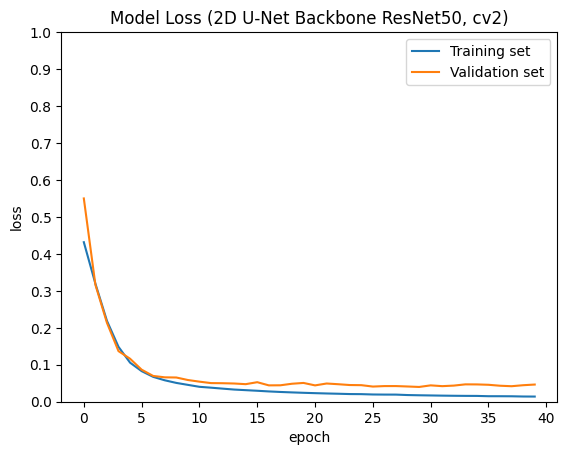

In [30]:
# Plot loss function
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('Model Loss (2D U-Net Backbone ResNet50, cv2)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training set', 'Validation set'], loc='upper right')

In [ ]:
model.save('/content/drive/MyDrive/2DPart/2Dmodel/resnet50_2D_aug_cv9.h5')

In [ ]:
# Prediction DICE
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)

    dice = (2.0 * intersection) / (union + 1e-8)
    return dice

In [ ]:
re_prediction = model.predict(test_original_2D)
binary_re = (re_prediction > 0.5).astype(int)

2/2 [==============================] - 12s 15ms/step


In [ ]:
D_re = dice_coefficient(test_mask_2D[:,:,:,0], binary_re[:,:,:,0])
print("DICE of using the resnet50 as encoder:", D_re)